Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [2]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [30]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('Correct_train_26.csv', sep=';'))
#for_ml = get_for_learn_clean_df(pd.read_csv('Test_set_best.csv', sep=';'))
#for_ml = for_ml[for_ml['wellName'] != 'cgr402']
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD           AGR           ANK           ASP             BK  \
count  62052.000000  62052.000000  20147.000000  56382.000000   49278.000000   
mean    2400.068236    -54.496483    -28.972717    -64.103100      18.505071   
std      317.995578    739.235019    544.910574    799.747484    1119.364186   
min     1850.200000  -9999.000000  -9999.000000  -9999.000000   -9999.000000   
25%     2137.600000      0.231149      0.727198      0.039976       5.750000   
50%     2401.800000      0.447123      0.843210      0.145837       7.140000   
75%     2615.000000      0.663160      0.941716      0.421520       8.800000   
max     3270.800000      1.000000      1.000000      1.000000  116144.860000   

            Facies    Facies_LIT            GR           LIT          NKTB  \
count  62052.00000  62052.000000  62052.000000  57645.000000  62052.000000   
mean   -9201.17864  -9802.650841    -55.516643  -5397.214433   -745.140925   
std     2710.06630   1387.656958    809.993753   4984.507453   2633.227706   
min    -9999.00000  -9999.000000  -9999.000000  -9999.000000  -9999.000000   
25%    -9999.00000  -9999.000000      7.338000  -9999.000000      3.381390   
50%    -9999.00000  -9999.000000      9.457000  -9999.000000      3.821395   
75%    -9999.00000  -9999.000000     11.800000      1.000000      4.417928   
max       12.00000     12.000000    108.920000      6.000000     24.130000   

                 SP  
count  60789.000000  
mean      -7.994457  
std     1064.404907  
min    -9999.000000  
25%       75.261400  
50%      105.912000  
75%      134.528000  
max      218.061000

wellName      MD       AGR  ANK       ASP     BK  Facies  Facies_LIT  \
651    spk1036  1850.2  0.465056  NaN  0.134255  4.600   -9999       -9999   
652    spk1036  1850.4  0.561146  NaN  0.163854  6.300   -9999       -9999   
653    spk1036  1850.6  0.689265  NaN  0.200832  6.300   -9999       -9999   
654    spk1036  1850.8  0.643000  NaN  0.230431  6.700   -9999       -9999   
655    spk1036  1851.0  0.566484  NaN  0.241584  6.800   -9999       -9999   
...        ...     ...       ...  ...       ...    ...     ...         ...   
76602  spk432R  2664.4  0.234586  1.0  0.000000  5.869   -9999       -9999   
76603  spk432R  2664.6  0.274610  1.0  0.000000  6.166   -9999       -9999   
76604  spk432R  2664.8  0.203586  1.0  0.000000  7.917   -9999       -9999   
76605  spk432R  2665.0  0.107808  1.0  0.000000  8.308   -9999       -9999   
76606  spk432R  2665.2  0.110353  1.0  0.000000  8.206   -9999       -9999   

           GR  LAYER     LIT     NKTB       SP  
651     7.030  -9999 -9999.0  2.80000   73.300  
652     6.490  -9999 -9999.0  3.00000   70.900  
653     5.770  -9999 -9999.0  3.09000   67.900  
654     6.030  -9999 -9999.0  2.85000   65.500  
655     6.460  -9999 -9999.0  2.53000   64.600  
...       ...    ...     ...      ...      ...  
76602  14.252     U1     1.0  3.15011  198.362  
76603  13.906     U1     1.0  3.06579  198.828  
76604  14.520     U1     1.0  2.98865  198.490  
76605  15.348     U1     1.0  2.54313  198.255  
76606  15.326     U1     1.0  2.50426  198.267  

[62052 rows x 13 columns]

['spk1036' 'spk1150' 'spk1518' 'spk1519' 'spk1521' 'spk1527' 'spk1743'
 'spk1746' 'spk1747' 'spk1749PL' 'spk1750PL' 'spk1768' 'spk1769'
 'spk1779PL' 'spk1799PL' 'spk400' 'spk403' 'spk405R' 'spk409R' 'spk420R'
 'spk424R' 'spk426R' 'spk427R' 'spk428R' 'spk429L' 'spk432R']


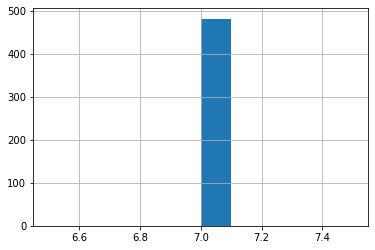

In [4]:
for_ml[for_ml['Facies'] == 7]['Facies'].hist()

In [5]:
for_ml[for_ml['Facies'] == 7]['wellName'].unique()

array(['spk1519', 'spk1521', 'spk1527', 'spk1749PL', 'spk400', 'spk424R',
       'spk429L'], dtype=object)

In [6]:
wells_samples_df[7]

wellName      MD          AGR  ANK          ASP     BK  Facies  \
21482  spk1746  1685.0     0.750140  NaN     0.649053  6.175   -9999   
21483  spk1746  1685.2     0.739108  NaN     0.668145  6.274   -9999   
21484  spk1746  1685.4     0.939866  NaN     0.694172  6.374   -9999   
21485  spk1746  1685.6     1.000000  NaN     0.722242  6.388   -9999   
21486  spk1746  1685.8     0.885325  NaN     0.731986  6.321   -9999   
...        ...     ...          ...  ...          ...    ...     ...   
26377  spk1746  2664.0 -9999.000000  NaN -9999.000000  0.000   -9999   
26378  spk1746  2664.2 -9999.000000  NaN -9999.000000  0.000   -9999   
26379  spk1746  2664.4 -9999.000000  NaN -9999.000000  0.000   -9999   
26380  spk1746  2664.6 -9999.000000  NaN -9999.000000  0.000   -9999   
26381  spk1746  2664.8 -9999.000000  NaN -9999.000000  0.000   -9999   

       Facies_LIT        GR  LAYER     LIT      NKTB         SP  
21482       -9999     6.857  -9999 -9999.0     3.043    89.8328  
21483       -9999     6.928  -9999 -9999.0     3.295    88.3378  
21484       -9999     5.636  -9999 -9999.0     3.191    86.2998  
21485       -9999     5.182  -9999 -9999.0     3.171    84.1018  
21486       -9999     5.987  -9999 -9999.0     3.219    83.3388  
...           ...       ...    ...     ...       ...        ...  
26377       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26378       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26379       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26380       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  
26381       -9999 -9999.000    UV2     1.0 -9999.000 -9999.0000  

[4900 rows x 13 columns]

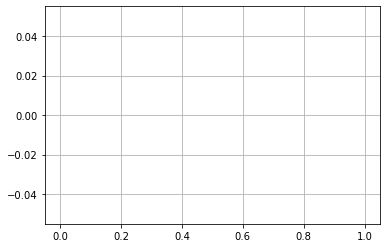

In [7]:
wells_samples_df[7][wells_samples_df[7]['Facies'] > 0]['Facies'].hist()

In [31]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1
        #min_ = well_copy[name_feature_extraction].min()
        #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
            #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x - abs(min_))
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        
#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower
        del well_copy[name_feature_extraction]
        well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


#well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['GR'], [0.2])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
GR_0
GR_1


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\iteration2\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
0


In [32]:




def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = pd.concat(well_with_features)

for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
for_ml_preprocessing = for_ml_preprocessing.fillna(-9999)


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    del well_copy['Facies_LIT']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = for_ml_preprocessing#get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LAYER']
    del feature['Facies_LIT']
    #del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

AGR           ANK           ASP             BK        Facies  \
count  61883.000000  61883.000000  61883.000000   61883.000000  61883.000000   
mean     -54.646978  -6770.550106   -971.489450   -2044.125282      3.030121   
std      740.238140   4675.611592   2961.882178    4172.072980      0.345804   
min    -9999.000000  -9999.000000  -9999.000000   -9999.000000      3.000000   
25%        0.230920  -9999.000000      0.020766       3.590000      3.000000   
50%        0.446320  -9999.000000      0.118577       6.447000      3.000000   
75%        0.662579      0.713559      0.373123       8.249250      3.000000   
max        1.000000      1.000000      1.000000  116144.860000      7.000000   

         Facies_LIT            GR           LIT            MD          NKTB  \
count  61883.000000  61883.000000  61883.000000  61883.000000  61883.000000   
mean   -9805.186756    -55.690275  -5724.323433   2400.636139   -747.186058   
std     1378.841987    811.092212   4947.474474    317.657301   2636.529704   
min    -9999.000000  -9999.000000  -9999.000000   1850.200000  -9999.000000   
25%    -9999.000000      7.340000  -9999.000000   2138.400000      3.381380   
50%    -9999.000000      9.461400  -9999.000000   2402.000000      3.821900   
75%    -9999.000000     11.803450      1.000000   2615.400000      4.420000   
max       12.000000    108.920000      6.000000   3270.800000     24.130000   

                 SP  interval_lenght_GRinterval_0.2_  max_GRinterval_0.2_GR  \
count  61883.000000                     61883.000000           61883.000000   
mean    -209.088685                        25.946754               9.878651   
std     1754.743083                        66.351655             166.266868   
min    -9999.000000                         1.000000           -9999.000000   
25%       73.900000                         6.000000               8.910000   
50%      105.200000                        15.000000              11.350000   
75%      133.800000                        27.000000              13.250000   
max      218.061000                       644.000000             108.920000   

       min_GRinterval_0.2_GR  
count           61883.000000  
mean              -73.066269  
std               900.372911  
min             -9999.000000  
25%                 6.130000  
50%                 7.710000  
75%                 9.995950  
max                91.353000

AGR     ANK       ASP     BK      GR     LIT     NKTB       SP  \
651    0.465056 -9999.0  0.134255  4.600   7.030 -9999.0  2.80000   73.300   
652    0.561146 -9999.0  0.163854  6.300   6.490 -9999.0  3.00000   70.900   
653    0.689265 -9999.0  0.200832  6.300   5.770 -9999.0  3.09000   67.900   
654    0.643000 -9999.0  0.230431  6.700   6.030 -9999.0  2.85000   65.500   
655    0.566484 -9999.0  0.241584  6.800   6.460 -9999.0  2.53000   64.600   
...         ...     ...       ...    ...     ...     ...      ...      ...   
76602  0.234586     1.0  0.000000  5.869  14.252     1.0  3.15011  198.362   
76603  0.274610     1.0  0.000000  6.166  13.906     1.0  3.06579  198.828   
76604  0.203586     1.0  0.000000  7.917  14.520     1.0  2.98865  198.490   
76605  0.107808     1.0  0.000000  8.308  15.348     1.0  2.54313  198.255   
76606  0.110353     1.0  0.000000  8.206  15.326     1.0  2.50426  198.267   

       interval_lenght_GRinterval_0.2_  max_GRinterval_0.2_GR  \
651                                 23                  7.110   
652                                 23                  7.110   
653                                 23                  7.110   
654                                 23                  7.110   
655                                 23                  7.110   
...                                ...                    ...   
76602                                3                 14.520   
76603                                3                 14.520   
76604                                3                 15.348   
76605                                3                 15.348   
76606                                3                 15.348   

       min_GRinterval_0.2_GR  
651                    5.110  
652                    5.110  
653                    5.110  
654                    5.110  
655                    5.110  
...                      ...  
76602                 13.906  
76603                 13.906  
76604                 14.520  
76605                 14.520  
76606                 14.520  

[61883 rows x 11 columns]

In [11]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    rfe = RFE(model, 4)
    rfe = rfe.fit(X_train, y_train)
    p(y_test, rfe.predict(X_test))
    p_cross_val(rfe, train, labels)
    return rfe

logistic_regression(features, target_facies)  

logistic_regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

KeyboardInterrupt: 

In [25]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 0.1057439984449412
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     20442
           7       0.00      0.00      0.00       136

    accuracy                           0.99     20578
   macro avg       0.50      0.50      0.50     20578
weighted avg       0.99      0.99      0.99     20578

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.99      1.00      1.00     68126
           7       0.00      0.00      0.00       466

    accuracy                           0.99     68592
   macro avg       0.50      0.50      0.50     68592
weighted avg       0.99      0.99      0.99     68592



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [37]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17894
           7       0.88      0.93      0.90        76

    accuracy                           1.00     17970
   macro avg       0.94      0.97      0.95     17970
weighted avg       1.00      1.00      1.00     17970

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       1.00      0.98      0.99     59651
           7       0.10      0.58      0.17       247

    accuracy                           0.98     59898
   macro avg       0.55      0.78      0.58     59898
weighted avg       0.99      0.98      0.98     59898

 n_neighbors 
2


KeyboardInterrupt: 

In [39]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 0.023149693934335004
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17898
           7       0.85      0.78      0.81        72

    accuracy                           1.00     17970
   macro avg       0.92      0.89      0.91     17970
weighted avg       1.00      1.00      1.00     17970

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      0.97      0.98     59651
           7       0.06      0.45      0.11       247

    accuracy                           0.97     59898
   macro avg       0.53      0.71      0.55     59898
weighted avg       0.99      0.97      0.98     59898



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [13]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True,criterion='entropy',
            n_estimators=100, n_jobs=-1,warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     68280
           7       1.00      1.00      1.00       481

    accuracy                           1.00     68761
   macro avg       1.00      1.00      1.00     68761
weighted avg       1.00      1.00      1.00     68761

cross_val_predict
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     68280
           7       0.30      0.17      0.22       481

    accuracy                           0.99     68761
   macro avg       0.65      0.58      0.61     68761
weighted avg       0.99      0.99      0.99     68761



In [40]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 2)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.011574846967167502
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     17898
           7       0.98      0.83      0.90        72

    accuracy                           1.00     17970
   macro avg       0.99      0.92      0.95     17970
weighted avg       1.00      1.00      1.00     17970

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     59651
           7       0.84      0.38      0.52       247

    accuracy                           1.00     59898
   macro avg       0.92      0.69      0.76     59898
weighted avg       1.00      1.00      1.00     59898



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=18, verbose=0,
                       warm_start=False)

In [33]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    train_copy = train.copy()
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            train_copy[_] = train_copy[_].apply(lambda x: str(x))
            cat_features.append(index)
        index +=1
    print(cat_features)
    print(train_copy)
    cv_dataset = Pool(data=train_copy,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = get_cb_data_all(X_train,y_train)
    test_data = get_cb_data_all(X_test,y_test)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

    params = {"iterations": 100,
              #"depth": 5,
              "loss_function": "Logloss",
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=10, 
                plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model
get_catBoost_iterations(features.dropna(), target_facies, 39)

[5]
            AGR          ANK       ASP          BK       GR      LIT  \
67454  0.000000     0.795960  0.014277 -9999.00000  18.0350  -9999.0   
73046  0.000000     1.000000  0.000000    13.60000  15.8000  -9999.0   
40147  0.277701 -9999.000000  0.000000     5.65470  11.9951      1.0   
74877  0.166975     1.000000  0.037231     8.99025  13.6930      1.0   
27139  0.631348 -9999.000000  0.454754     8.22000   8.8900  -9999.0   
...         ...          ...       ...         ...      ...      ...   
2379   0.872546 -9999.000000  0.703508     8.90000   4.7400      4.0   
40627  0.311094 -9999.000000  0.189951     6.88840  11.6891      1.0   
29186  0.610437 -9999.000000  0.812957     8.91000   9.0900  -9999.0   
33292  0.602163 -9999.000000  0.268556     6.85350   9.0522  -9999.0   
75426  0.572110     0.846275  0.117626     6.85050   9.6000      2.0   

             NKTB         SP  interval_lenght_GRinterval_0.2_  \
67454     4.00367  167.98100                               34   
7

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [35]:


def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = get_cb_data_all(X_train,y_train)
    test_data = get_cb_data_all(X_test,y_test)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

#     params = {"iterations": 100,
#               #"depth": 5,
#               "loss_function": "Logloss",
#               "verbose": False}

#     scores = cv(cv_dataset,
#                 params,
#                 fold_count=10, 
#                 plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model

catBoost_prod_30 = get_catBoost_iterations(features, target_facies, 30)
catBoost_prod_42 = get_catBoost_iterations(features, target_facies, 42)
catBoost_prod_40 = get_catBoost_iterations(features, target_facies, 40)

[5]
            AGR          ANK       ASP          BK       GR      LIT  \
67454  0.000000     0.795960  0.014277 -9999.00000  18.0350  -9999.0   
73046  0.000000     1.000000  0.000000    13.60000  15.8000  -9999.0   
40147  0.277701 -9999.000000  0.000000     5.65470  11.9951      1.0   
74877  0.166975     1.000000  0.037231     8.99025  13.6930      1.0   
27139  0.631348 -9999.000000  0.454754     8.22000   8.8900  -9999.0   
...         ...          ...       ...         ...      ...      ...   
2379   0.872546 -9999.000000  0.703508     8.90000   4.7400      4.0   
40627  0.311094 -9999.000000  0.189951     6.88840  11.6891      1.0   
29186  0.610437 -9999.000000  0.812957     8.91000   9.0900  -9999.0   
33292  0.602163 -9999.000000  0.268556     6.85350   9.0522  -9999.0   
75426  0.572110     0.846275  0.117626     6.85050   9.6000      2.0   

             NKTB         SP  interval_lenght_GRinterval_0.2_  \
67454     4.00367  167.98100                               34   
7

RMSE ошибка равна 0.08675823682556782
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     55270
           7       0.91      0.32      0.48       425

    accuracy                           0.99     55695
   macro avg       0.95      0.66      0.74     55695
weighted avg       0.99      0.99      0.99     55695

[5]
            AGR     ANK       ASP     BK      GR      LIT     NKTB       SP  \
651    0.465056 -9999.0  0.134255  4.600   7.030  -9999.0  2.80000   73.300   
652    0.561146 -9999.0  0.163854  6.300   6.490  -9999.0  3.00000   70.900   
653    0.689265 -9999.0  0.200832  6.300   5.770  -9999.0  3.09000   67.900   
654    0.643000 -9999.0  0.230431  6.700   6.030  -9999.0  2.85000   65.500   
655    0.566484 -9999.0  0.241584  6.800   6.460  -9999.0  2.53000   64.600   
...         ...     ...       ...    ...     ...      ...      ...      ...   
76602  0.234586     1.0  0.000000  5.869  14.252      1.0  3.15011  198.362   

In [23]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    params = {'iterations':100, 'loss_function':'MultiClass'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

0:	learn: -1.8766562	total: 59.9ms	remaining: 5.93s
1:	learn: -1.8161878	total: 92.1ms	remaining: 4.51s
2:	learn: -1.7603130	total: 177ms	remaining: 5.72s
3:	learn: -1.7092819	total: 364ms	remaining: 8.73s
4:	learn: -1.6638310	total: 496ms	remaining: 9.41s
5:	learn: -1.6234121	total: 528ms	remaining: 8.28s
6:	learn: -1.5867336	total: 563ms	remaining: 7.47s
7:	learn: -1.5512661	total: 625ms	remaining: 7.19s
8:	learn: -1.5181065	total: 760ms	remaining: 7.68s
9:	learn: -1.4883427	total: 823ms	remaining: 7.41s
10:	learn: -1.4572618	total: 880ms	remaining: 7.12s
11:	learn: -1.4288494	total: 937ms	remaining: 6.87s
12:	learn: -1.4010733	total: 974ms	remaining: 6.52s
13:	learn: -1.3764982	total: 1.02s	remaining: 6.26s
14:	learn: -1.3530337	total: 1.07s	remaining: 6.04s
15:	learn: -1.3297139	total: 1.11s	remaining: 5.81s
16:	learn: -1.3070439	total: 1.15s	remaining: 5.62s
17:	learn: -1.2864910	total: 1.18s	remaining: 5.36s
18:	learn: -1.2656571	total: 1.2s	remaining: 5.13s
19:	learn: -1.2468436

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0:	learn: -1.8770403	total: 95.7ms	remaining: 9.47s
1:	learn: -1.8182400	total: 149ms	remaining: 7.31s
2:	learn: -1.7625397	total: 257ms	remaining: 8.32s
3:	learn: -1.7096715	total: 329ms	remaining: 7.9s
4:	learn: -1.6622429	total: 410ms	remaining: 7.78s
5:	learn: -1.6172590	total: 457ms	remaining: 7.17s
6:	learn: -1.5768128	total: 511ms	remaining: 6.78s
7:	learn: -1.5419569	total: 562ms	remaining: 6.47s
8:	learn: -1.5091596	total: 626ms	remaining: 6.33s
9:	learn: -1.4790142	total: 703ms	remaining: 6.33s
10:	learn: -1.4481192	total: 755ms	remaining: 6.11s
11:	learn: -1.4189957	total: 793ms	remaining: 5.82s
12:	learn: -1.3909137	total: 832ms	remaining: 5.57s
13:	learn: -1.3663830	total: 873ms	remaining: 5.37s
14:	learn: -1.3436657	total: 942ms	remaining: 5.34s
15:	learn: -1.3214113	total: 991ms	remaining: 5.2s
16:	learn: -1.3007105	total: 1.08s	remaining: 5.29s
17:	learn: -1.2785409	total: 1.11s	remaining: 5.06s
18:	learn: -1.2567657	total: 1.14s	remaining: 4.85s
19:	learn: -1.2378838	t

59:	learn: -0.8588360	total: 2.02s	remaining: 1.35s
60:	learn: -0.8536747	total: 2.05s	remaining: 1.31s
61:	learn: -0.8485269	total: 2.07s	remaining: 1.27s
62:	learn: -0.8430575	total: 2.1s	remaining: 1.23s
63:	learn: -0.8380197	total: 2.13s	remaining: 1.2s
64:	learn: -0.8328875	total: 2.15s	remaining: 1.16s
65:	learn: -0.8284790	total: 2.18s	remaining: 1.12s
66:	learn: -0.8245601	total: 2.21s	remaining: 1.09s
67:	learn: -0.8199806	total: 2.24s	remaining: 1.05s
68:	learn: -0.8161226	total: 2.26s	remaining: 1.02s
69:	learn: -0.8118817	total: 2.29s	remaining: 981ms
70:	learn: -0.8076731	total: 2.31s	remaining: 945ms
71:	learn: -0.8034085	total: 2.34s	remaining: 910ms
72:	learn: -0.7995398	total: 2.37s	remaining: 875ms
73:	learn: -0.7958382	total: 2.4s	remaining: 842ms
74:	learn: -0.7905936	total: 2.42s	remaining: 808ms
75:	learn: -0.7872279	total: 2.45s	remaining: 774ms
76:	learn: -0.7836730	total: 2.48s	remaining: 740ms
77:	learn: -0.7802822	total: 2.5s	remaining: 706ms
78:	learn: -0.77

20:	learn: -1.2163701	total: 723ms	remaining: 2.72s
21:	learn: -1.1993077	total: 763ms	remaining: 2.7s
22:	learn: -1.1851581	total: 790ms	remaining: 2.65s
23:	learn: -1.1692175	total: 818ms	remaining: 2.59s
24:	learn: -1.1548272	total: 847ms	remaining: 2.54s
25:	learn: -1.1432875	total: 874ms	remaining: 2.49s
26:	learn: -1.1302225	total: 902ms	remaining: 2.44s
27:	learn: -1.1150519	total: 979ms	remaining: 2.52s
28:	learn: -1.1013181	total: 1.02s	remaining: 2.5s
29:	learn: -1.0886149	total: 1.15s	remaining: 2.68s
30:	learn: -1.0768309	total: 1.18s	remaining: 2.62s
31:	learn: -1.0663798	total: 1.22s	remaining: 2.59s
32:	learn: -1.0561893	total: 1.26s	remaining: 2.55s
33:	learn: -1.0455185	total: 1.28s	remaining: 2.49s
34:	learn: -1.0345388	total: 1.31s	remaining: 2.44s
35:	learn: -1.0240446	total: 1.34s	remaining: 2.39s
36:	learn: -1.0141101	total: 1.38s	remaining: 2.35s
37:	learn: -1.0046482	total: 1.41s	remaining: 2.3s
38:	learn: -0.9951061	total: 1.46s	remaining: 2.28s
39:	learn: -0.9

80:	learn: -0.7409845	total: 4.96s	remaining: 1.16s
81:	learn: -0.7375812	total: 5s	remaining: 1.1s
82:	learn: -0.7338991	total: 5.04s	remaining: 1.03s
83:	learn: -0.7295089	total: 5.09s	remaining: 971ms
84:	learn: -0.7263230	total: 5.13s	remaining: 906ms
85:	learn: -0.7225105	total: 5.17s	remaining: 843ms
86:	learn: -0.7190264	total: 5.21s	remaining: 779ms
87:	learn: -0.7159725	total: 5.25s	remaining: 716ms
88:	learn: -0.7126796	total: 5.33s	remaining: 659ms
89:	learn: -0.7094307	total: 5.37s	remaining: 597ms
90:	learn: -0.7064985	total: 5.41s	remaining: 535ms
91:	learn: -0.7038388	total: 5.46s	remaining: 475ms
92:	learn: -0.7010002	total: 5.5s	remaining: 414ms
93:	learn: -0.6982996	total: 5.55s	remaining: 354ms
94:	learn: -0.6958087	total: 5.6s	remaining: 295ms
95:	learn: -0.6923725	total: 5.64s	remaining: 235ms
96:	learn: -0.6887652	total: 5.7s	remaining: 176ms
97:	learn: -0.6862581	total: 5.74s	remaining: 117ms
98:	learn: -0.6839956	total: 5.78s	remaining: 58.4ms
99:	learn: -0.6816

41:	learn: -0.9568958	total: 2.54s	remaining: 3.5s
42:	learn: -0.9480126	total: 2.59s	remaining: 3.43s
43:	learn: -0.9381059	total: 2.63s	remaining: 3.35s
44:	learn: -0.9313489	total: 2.68s	remaining: 3.28s
45:	learn: -0.9235270	total: 2.72s	remaining: 3.19s
46:	learn: -0.9163022	total: 2.77s	remaining: 3.13s
47:	learn: -0.9087017	total: 2.81s	remaining: 3.05s
48:	learn: -0.9029950	total: 2.86s	remaining: 2.97s
49:	learn: -0.8947694	total: 2.93s	remaining: 2.93s
50:	learn: -0.8887624	total: 2.97s	remaining: 2.85s
51:	learn: -0.8826369	total: 3.01s	remaining: 2.78s
52:	learn: -0.8768201	total: 3.06s	remaining: 2.71s
53:	learn: -0.8714014	total: 3.12s	remaining: 2.66s
54:	learn: -0.8649254	total: 3.18s	remaining: 2.6s
55:	learn: -0.8600642	total: 3.22s	remaining: 2.53s
56:	learn: -0.8536193	total: 3.31s	remaining: 2.5s
57:	learn: -0.8480021	total: 3.35s	remaining: 2.42s
58:	learn: -0.8419696	total: 3.39s	remaining: 2.35s
59:	learn: -0.8362372	total: 3.44s	remaining: 2.3s
60:	learn: -0.83

0:	learn: -1.8766465	total: 29.5ms	remaining: 2.92s
1:	learn: -1.8103353	total: 59.2ms	remaining: 2.9s
2:	learn: -1.7502180	total: 89ms	remaining: 2.88s
3:	learn: -1.6944607	total: 116ms	remaining: 2.79s
4:	learn: -1.6495364	total: 143ms	remaining: 2.71s
5:	learn: -1.6046605	total: 170ms	remaining: 2.66s
6:	learn: -1.5627536	total: 196ms	remaining: 2.6s
7:	learn: -1.5274561	total: 224ms	remaining: 2.58s
8:	learn: -1.4892678	total: 258ms	remaining: 2.6s
9:	learn: -1.4549835	total: 286ms	remaining: 2.57s
10:	learn: -1.4238151	total: 312ms	remaining: 2.52s
11:	learn: -1.3936659	total: 340ms	remaining: 2.49s
12:	learn: -1.3655572	total: 369ms	remaining: 2.47s
13:	learn: -1.3393249	total: 398ms	remaining: 2.44s
14:	learn: -1.3152980	total: 425ms	remaining: 2.41s
15:	learn: -1.2904677	total: 478ms	remaining: 2.51s
16:	learn: -1.2679643	total: 510ms	remaining: 2.49s
17:	learn: -1.2472669	total: 555ms	remaining: 2.53s
18:	learn: -1.2262540	total: 594ms	remaining: 2.53s
19:	learn: -1.2067927	to

60:	learn: -0.8023267	total: 2.28s	remaining: 1.46s
61:	learn: -0.7968903	total: 2.31s	remaining: 1.42s
62:	learn: -0.7929505	total: 2.34s	remaining: 1.37s
63:	learn: -0.7876139	total: 2.37s	remaining: 1.33s
64:	learn: -0.7819387	total: 2.39s	remaining: 1.29s
65:	learn: -0.7778829	total: 2.42s	remaining: 1.24s
66:	learn: -0.7729173	total: 2.44s	remaining: 1.2s
67:	learn: -0.7686189	total: 2.48s	remaining: 1.17s
68:	learn: -0.7640854	total: 2.5s	remaining: 1.12s
69:	learn: -0.7602721	total: 2.53s	remaining: 1.08s
70:	learn: -0.7554730	total: 2.56s	remaining: 1.04s
71:	learn: -0.7516980	total: 2.58s	remaining: 1s
72:	learn: -0.7477542	total: 2.61s	remaining: 966ms
73:	learn: -0.7446354	total: 2.64s	remaining: 926ms
74:	learn: -0.7402451	total: 2.67s	remaining: 891ms
75:	learn: -0.7356458	total: 2.7s	remaining: 853ms
76:	learn: -0.7331340	total: 2.73s	remaining: 816ms
77:	learn: -0.7296433	total: 2.76s	remaining: 778ms
78:	learn: -0.7261465	total: 2.79s	remaining: 742ms
79:	learn: -0.7225

# Предсказываем значения

In [36]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature

dataset_for_predict = get_clean_df(pd.read_csv('Correct_test_26.csv', sep=';'))
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['spk1205L' 'spk146R' 'spk1508' 'spk1528' 'spk1650PL' 'spk1656PL'
 'spk1700' 'spk1701' 'spk1703' 'spk1707' 'spk1710' 'spk1718' 'spk1725'
 'spk1740' 'spk1741' 'spk1742' 'spk1745L' 'spk1753' 'spk1755' 'spk1764'
 'spk1765' 'spk1779' 'spk1791' 'spk1792' 'spk1793' 'spk1794' 'spk1796'
 'spk1805' 'spk214P' 'spk236' 'spk401' 'spk404' 'spk408' 'spk421R'
 'spk422R' 'spk437' 'spk467' 'spk564P' 'spk632' 'spk804' 'spk805' 'spk808'
 'spk833R' 'spk870PL' 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914'
 'spk924L' 'spk941' 'spk963L']


In [38]:
# %load_ext autoreload
# from feature_interval_extraction import get_interval_collector

# def savitzky_golay(y, window_size, order, deriv=0, rate=1):
#     r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
#     The Savitzky-Golay filter removes high frequency noise from data.
#     It has the advantage of preserving the original shape and
#     features of the signal better than other types of filtering
#     approaches, such as moving averages techniques.
#     Parameters
#     ----------
#     y : array_like, shape (N,)
#         the values of the time history of the signal.
#     window_size : int
#         the length of the window. Must be an odd integer number.
#     order : int
#         the order of the polynomial used in the filtering.
#         Must be less then `window_size` - 1.
#     deriv: int
#         the order of the derivative to compute (default = 0 means only smoothing)
#     Returns
#     -------
#     ys : ndarray, shape (N)
#         the smoothed signal (or it's n-th derivative).
#     Notes
#     -----
#     The Savitzky-Golay is a type of low-pass filter, particularly
#     suited for smoothing noisy data. The main idea behind this
#     approach is to make for each point a least-square fit with a
#     polynomial of high order over a odd-sized window centered at
#     the point.
#     Examples
#     --------
#     t = np.linspace(-4, 4, 500)
#     y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
#     ysg = savitzky_golay(y, window_size=31, order=4)
#     import matplotlib.pyplot as plt
#     plt.plot(t, y, label='Noisy signal')
#     plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
#     plt.plot(t, ysg, 'r', label='Filtered signal')
#     plt.legend()
#     plt.show()
#     References
#     ----------
#     .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
#        Data by Simplified Least Squares Procedures. Analytical
#        Chemistry, 1964, 36 (8), pp 1627-1639.
#     .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
#        W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
#        Cambridge University Press ISBN-13: 9780521880688
#     """
#     import numpy as np
#     from math import factorial

#     try:
#         window_size = np.abs(np.int(window_size))
#         order = np.abs(np.int(order))
#     except ValueError:
#         raise ValueError("window_size and order have to be of type int")
#         if window_size % 2 != 1 or window_size < 1:
#             raise TypeError("window_size size must be a positive odd number")
#         if window_size < order + 2:
#             raise TypeError("window_size is too small for the polynomials order")
#     order_range = range(order+1)
#     half_window = (window_size -1) // 2
#     # precompute coefficients
#     b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
#     m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
#     # pad the signal at the extremes with
#     # values taken from the signal itself
#     firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
#     lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
#     y = np.concatenate((firstvals, y, lastvals))
#     return np.convolve( m[::-1], y, mode='valid')

# def get_df_interval_result(well, intervals):
#     dfs_parts = []
#     for interval in intervals:
#         min_ = interval['MD_min']
#         max_ = interval['MD_max']
#         if min_ < max_:
#             df_part_min = well[well['MD'] >= min_]
#             df_part = df_part_min[df_part_min['MD'] <= max_]
#         else:
#             df_part_min = well[well['MD'] <= min_]
#             df_part = df_part_min[df_part_min['MD'] >= max_]
#         dfs_parts.append(df_part)
#     all = pd.concat(dfs_parts)
#     return all.drop_duplicates()


# def get_df_intervals_result(well, intervals):
#     dfs_parts = []
#     for interval in intervals:
#         min_ = interval['MD_min']
#         max_ = interval['MD_max']
#         if min_ < max_:
#             df_part_min = well[well['MD'] >= min_]
#             df_part = df_part_min[df_part_min['MD'] <= max_]
#         else:
#             df_part_min = well[well['MD'] <= min_]
#             df_part = df_part_min[df_part_min['MD'] >= max_]
#         dfs_parts.append(df_part)
#     return dfs_parts


# def get_df_middle_intervals_result(well, intervals):
#     def get_left_md(interval):
#         min_ = interval['MD_min']
#         max_ = interval['MD_max']
#         if min_ < max_:
#             return min_
#         else:
#             return max_

#     def get_right_md(interval):
#         min_ = interval['MD_min']
#         max_ = interval['MD_max']
#         if min_ < max_:
#             return max_
#         else:
#             return min_

#     if len(intervals) == 0:
#         return 0
#     well_copy = well.copy()
#     if len(intervals) == 1:
#         left = get_left_md(intervals[0])
#         right = get_right_md(intervals[0])
#         left_df = well_copy[well_copy['MD'] < left]
#         right_df = well_copy[well_copy['MD'] > right]
#         return [left_df, right_df]

#     middle_interval_dfs = []
#     for index, interval in enumerate(intervals):
#         if index == 0:
#             left = get_left_md(intervals[index])
#             left_df = well_copy[well_copy['MD'] < left]
#             middle_interval_dfs.append(left_df)
#             continue
#         if index == len(intervals) - 1:
#             right = get_right_md(intervals[index])
#             right_df = well_copy[well_copy['MD'] > right]
#             middle_interval_dfs.append(right_df)
#             continue
#         right_current = get_right_md(intervals[index])
#         left_next = get_left_md(intervals[index + 1])
#         df_part_right = well_copy[well_copy['MD'] > right_current]
#         df_part = df_part_right[df_part_right['MD'] < left_next]
#         if not df_part.empty:
#             middle_interval_dfs.append(df_part)
#     return middle_interval_dfs


# def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
#     results = []
#     for interval_df_ in middle_interval_dfs:
#         part = interval_df_.copy()
#         part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
#         for name in feature_names:
#             part['max_' + new_feature_prefix + name] = part[name].max()
#             part['min_' + new_feature_prefix + name] = part[name].min()
# #             if part[name].max() == part[name].min():
# #                 part['std_' + new_feature_prefix + name] = 0
# #             else:
# #                 part['std_' + new_feature_prefix + name] = part[name].std()
# #             part['mean_' + new_feature_prefix + name] = part[name].mean()
#         results.append(part)
#     return pd.concat(results)

# def min_shift_corrector(middle_interval_dfs, shift_corrector):
#     results = []
#     for interval_df_ in middle_interval_dfs:
#         part = interval_df_.copy()
#         for name in feature_names:
#             ppart[name] = part[name] - abs(shift_corrector)
#         results.append(part)
#     return pd.concat(results)


# def get_with_interval_feature_extraction(well, features_name_for_extraction,
#                                          percent_change_border, new_feature_prefix, features_name_for_statistic):
#     intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
#     interval_df = get_df_intervals_result(well, intervals)
#     middle_interval_df = get_df_middle_intervals_result(well, intervals)
#     with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
#                                                        new_feature_prefix)
#     with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
#     concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
#     remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
#     return remove_duplicates.sort_index()


# def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
#     results = []
#     for interval_df_ in middle_interval_dfs:
#         part = interval_df_.copy()
#         part['max_' + new_column_name] = part[feature_sp_gr].max()
#         part['min_' + new_column_name] = part[feature_sp_gr].min()
#         results.append(part)
#     return pd.concat(results)


# def add_interval_column_nulls(middle_interval_dfs, new_column_name):
#     results = []
#     for interval_df_ in middle_interval_dfs:
#         part = interval_df_.copy()
#         part['max_' + new_column_name] = -9999
#         part['min_' + new_column_name] = -9999
#         results.append(part)
#     return pd.concat(results)


# def get_column_with_interval(well, features_name_for_extraction,
#                              percent_change_border, new_column_name, feature_sp_or_gr):
#     intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
#     interval_df = get_df_intervals_result(well, intervals)
#     middle_interval_df = get_df_middle_intervals_result(well, intervals)
#     with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
#     with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
#     concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
#     remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
#     return remove_duplicates.sort_index()


# def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
#     wells_return = []
#     wells_nulls = []
#     index_well = 0
#     for well in wells:
#         try:
#             well_copy = well.copy()

#             name_feature_extraction = feature_names[0] + '_savitzky_golay'
#             print(feature_names[0] + '_' + str(index_well))
#             well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
#             index_well = index_well + 1

#             for border in percents_borders:
#                 new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
#                 well_copy = get_with_interval_feature_extraction(well=well_copy,
#                                                                  features_name_for_extraction=name_feature_extraction,
#                                                                  percent_change_border=border,
#                                                                  new_feature_prefix=new_feature_prefix,
#                                                                  features_name_for_statistic=feature_names)

#             del well_copy[name_feature_extraction]
#             well_copy.fillna(-9999)
#             wells_return.append(well_copy)
            
#         except:
#             display(well_copy)
#             display(well_copy.describe())

#     print(len(wells_nulls))
#     return wells_return
# display(wells_samples_df_prod[50])
#well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['SP'], [0.2])
well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['GR'], [0.2])


GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
GR_27
GR_28
GR_29
GR_30
GR_31
GR_32
GR_33
GR_34
GR_35
GR_36
GR_37
GR_38
GR_39
GR_40
GR_41
GR_42
GR_43
GR_44
GR_45
GR_46
GR_47
GR_48
GR_49
GR_50
GR_51
0


In [39]:
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

AGR       ANK       ASP     BK     GR  LAYER     LIT      MD  \
9236    0.850218  0.727724  0.134764  22.16   4.80  -9999 -9999.0  1850.2   
9237    0.887429  0.633109  0.114327  29.10   4.57  -9999 -9999.0  1850.4   
9238    0.725643  0.713389  0.103360   9.22   5.57  -9999 -9999.0  1850.6   
9244    0.484582  1.000000  0.064585   4.72   7.06  -9999 -9999.0  1851.8   
9245    0.461932  1.000000  0.067820   4.86   7.20  -9999 -9999.0  1852.0   
...          ...       ...       ...    ...    ...    ...     ...     ...   
534978  0.000000  0.982557  0.011250   7.30  10.13  UV1_3 -9999.0  2807.2   
534979  0.000000  0.976879  0.025836   7.70  10.06  UV1_3 -9999.0  2807.4   
534980  0.000000  0.942811  0.032466   7.50   9.60  UV1_3 -9999.0  2807.6   
534981  0.115482  0.681621  0.036444   6.60   8.29  UV1_3 -9999.0  2807.8   
534982  0.115482  0.681621  0.036444   6.60   8.29  UV1_3 -9999.0  2808.0   

        NKTB         SP  interval_lenght_GRinterval_0.2_  \
9236    3.11   99.51489                                3   
9237    3.44  100.85300                                3   
9238    3.16  101.57120                                3   
9244    1.91  104.11010                                2   
9245    1.98  103.89830                                2   
...      ...        ...                              ...   
534978  1.90   98.00000                               13   
534979  1.91   96.90000                               13   
534980  1.97   96.40000                               13   
534981  2.43   96.10000                               13   
534982  2.43   96.10000                               13   

        max_GRinterval_0.2_GR  min_GRinterval_0.2_GR  wellName  
9236                     5.57                   4.57  spk1205L  
9237                     5.57                   4.57  spk1205L  
9238                     5.57                   4.57  spk1205L  
9244                     7.20                   7.06  spk1205L  
9245                     7.20                   7.06  spk1205L  
...                       ...                    ...       ...  
534978                  10.49                   8.29   spk963L  
534979                  10.49                   8.29   spk963L  
534980                  10.49                   8.29   spk963L  
534981                  10.49                   8.29   spk963L  
534982                  10.49                   8.29   spk963L  

[234074 rows x 14 columns]

In [40]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    #del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        print(x)
        return undefined_value
    if math.isnan(x):
        print(x)
        return undefined_value
    if math.isinf(x):
        print(x)
        return undefined_value
    if x > -99999:
        return int(x) 
    print(x)

for_predict_df_prod = for_ml_preprocessing_prod.dropna().fillna(-9999)
for_predict_df_prod['LIT'] = for_predict_df_prod['LIT'].apply(change_null)
#for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

In [41]:
for_predict_df

AGR       ANK       ASP     BK     GR   LIT  NKTB         SP  \
9236    0.850218  0.727724  0.134764  22.16   4.80 -9999  3.11   99.51489   
9237    0.887429  0.633109  0.114327  29.10   4.57 -9999  3.44  100.85300   
9238    0.725643  0.713389  0.103360   9.22   5.57 -9999  3.16  101.57120   
9244    0.484582  1.000000  0.064585   4.72   7.06 -9999  1.91  104.11010   
9245    0.461932  1.000000  0.067820   4.86   7.20 -9999  1.98  103.89830   
...          ...       ...       ...    ...    ...   ...   ...        ...   
534978  0.000000  0.982557  0.011250   7.30  10.13 -9999  1.90   98.00000   
534979  0.000000  0.976879  0.025836   7.70  10.06 -9999  1.91   96.90000   
534980  0.000000  0.942811  0.032466   7.50   9.60 -9999  1.97   96.40000   
534981  0.115482  0.681621  0.036444   6.60   8.29 -9999  2.43   96.10000   
534982  0.115482  0.681621  0.036444   6.60   8.29 -9999  2.43   96.10000   

        interval_lenght_GRinterval_0.2_  max_GRinterval_0.2_GR  \
9236                                  3                   5.57   
9237                                  3                   5.57   
9238                                  3                   5.57   
9244                                  2                   7.20   
9245                                  2                   7.20   
...                                 ...                    ...   
534978                               13                  10.49   
534979                               13                  10.49   
534980                               13                  10.49   
534981                               13                  10.49   
534982                               13                  10.49   

        min_GRinterval_0.2_GR  
9236                     4.57  
9237                     4.57  
9238                     4.57  
9244                     7.06  
9245                     7.06  
...                       ...  
534978                   8.29  
534979                   8.29  
534980                   8.29  
534981                   8.29  
534982                   8.29  

[201079 rows x 11 columns]

In [42]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset


for_predict_df_prod['catBoost_prod_30'] = catBoost_prod_30.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_40'] = catBoost_prod_40.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_42'] = catBoost_prod_42.predict(get_cb_data_all_prod(for_predict_df))
# for_predict_df_prod['catBoost_prod_100'] = catBoost_prod_100.predict(get_cb_data_all_prod(for_predict_df))
# for_predict_df_prod['random'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)

In [43]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost_prod_30']
    f_3 = row['catBoost_prod_40']
    f_1 = row['catBoost_prod_42']

    if f_0 == f_1 and f_3 == f_1:
        return f_0
    return 3
for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [46]:
for_predict_df_prod[for_predict_df_prod['catBoost'] > 3]

AGR       ANK       ASP     BK    GR  LAYER   LIT      MD  NKTB  \
10066   0.749911  0.773599  0.126874  14.12  5.42  -9999 -9999  2016.2  2.95   
10720   0.727261  0.377933  0.272775  24.78  5.56  -9999 -9999  2147.0  4.33   
10835   0.808154  0.461080  0.378165  13.30  5.06  -9999 -9999  2170.0  4.04   
10836   0.845365  0.334926  0.299314  12.03  4.83  -9999 -9999  2170.2  4.48   
10837   0.808154  0.509821  0.268112  12.01  5.06  -9999 -9999  2170.4  3.87   
...          ...       ...       ...    ...   ...    ...   ...     ...   ...   
534508  0.669438  0.579416  0.202197  17.00  5.51  -9999 -9999  2713.2  2.61   
534792  0.699327  0.585094  0.159765  18.90  5.36  UV1_1     5  2770.0  2.60   
534793  0.705306  0.579416  0.161091  11.00  5.33  UV1_1     5  2770.2  2.61   
534794  0.731210  0.607806  0.163743   9.90  5.20  UV1_1     5  2770.4  2.56   
534795  0.679401  0.619162  0.191589   8.20  5.46  UV1_1     1  2770.6  2.54   

               SP  interval_lenght_GRinterval_0.2_  max_GRinterval_0.2_GR  \
10066   100.03150                                5                   6.59   
10720    90.47815                               87                   9.20   
10835    83.57742                                3                   5.06   
10836    88.74046                                3                   5.06   
10837    90.78349                                3                   5.06   
...           ...                              ...                    ...   
534508   83.60000                                4                   7.29   
534792   86.80000                               11                   6.40   
534793   86.70000                                3                   5.46   
534794   86.50000                                3                   5.46   
534795   84.40000                                3                   5.46   

        min_GRinterval_0.2_GR  wellName  catBoost_prod_30  catBoost_prod_40  \
10066                    5.31  spk1205L               7.0               7.0   
10720                    4.91  spk1205L               7.0               7.0   
10835                    4.83  spk1205L               7.0               7.0   
10836                    4.83  spk1205L               7.0               7.0   
10837                    4.83  spk1205L               7.0               7.0   
...                       ...       ...               ...               ...   
534508                   5.49   spk963L               7.0               7.0   
534792                   5.32   spk963L               7.0               7.0   
534793                   5.20   spk963L               7.0               7.0   
534794                   5.20   spk963L               7.0               7.0   
534795                   5.20   spk963L               7.0               7.0   

        catBoost_prod_42  catBoost  
10066                7.0       7.0  
10720                7.0       7.0  
10835                7.0       7.0  
10836                7.0       7.0  
10837                7.0       7.0  
...                  ...       ...  
534508               7.0       7.0  
534792               7.0       7.0  
534793               7.0       7.0  
534794               7.0       7.0  
534795               7.0       7.0  

[1282 rows x 18 columns]

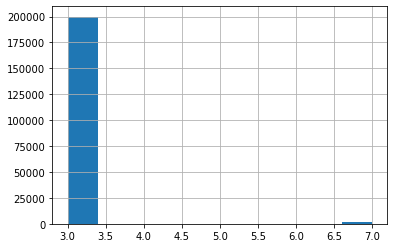

In [47]:
for_predict_df_prod['catBoost'].hist()

In [48]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'catBoost' and 
            name_feature != 'random' and 
            name_feature != 'catBoost_prod_30' and 
            name_feature != 'catBoost_prod_40' and 
            name_feature != 'catBoost_prod_42' and
            name_feature != 'catBoost_prod_100'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_7_facies_catBoost_intervals_train_correct_26.csv', index=False)
    
save(for_predict_df_prod)

AGR
ANK
ASP
BK
GR
LIT
NKTB
SP
interval_lenght_GRinterval_0.2_
max_GRinterval_0.2_GR
min_GRinterval_0.2_GR
